In [26]:
import warnings   # We will turn of the future warnings that xgboost gives us
warnings.simplefilter(action='ignore', category=FutureWarning)
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import nltk
import torch
import torchvision
import torchtext
import re
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from re import findall, sub

nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.metrics import f1_score
from sklearn.svm import SVR
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pandas import get_dummies

from torch import nn
from torch.nn import functional
from torch.utils.data import DataLoader, TensorDataset

from torchtext.data import get_tokenizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
import datasets

# loads the dataset from https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech.
# the "train" split is the only split in the dataset, so we need to separate this.
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', split = 'train')

df = dataset.to_pandas()
df.describe()



,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,annotator_age
count,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.00000,135556.000000,135556.000000,135556.000000,135556.000000,...,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135451.000000
mean,23530.416138,5567.097812,1.281352,2.954307,2.828875,2.56331,2.278638,2.698575,1.846211,1.052045,...,0.744733,-0.567428,1.034322,1.001052,-0.018817,0.300588,1.007158,1.011841,0.014589,37.910772
std,12387.194125,3230.508937,1.023542,1.231552,1.309548,1.38983,1.370876,0.898500,1.402372,1.345706,...,0.932260,2.380003,0.496867,0.791943,0.487261,0.236380,0.269876,0.675863,0.613006,11.641276
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-8.340000,0.100000,0.070000,-1.820000,0.020000,0.390000,0.280000,-1.578693,18.000000
25%,18148.000000,2719.000000,0.000000,2.000000,2.000000,2.00000,1.000000,2.000000,1.000000,0.000000,...,0.000000,-2.330000,0.710000,0.560000,-0.380000,0.030000,0.810000,0.670000,-0.341008,29.000000
50%,20052.000000,5602.500000,1.000000,3.000000,3.000000,3.00000,3.000000,3.000000,2.000000,0.000000,...,0.000000,-0.340000,0.960000,0.830000,-0.020000,0.340000,0.970000,0.850000,0.110405,35.000000
75%,32038.250000,8363.000000,2.000000,4.000000,4.000000,4.00000,3.000000,3.000000,3.000000,2.000000,...,2.000000,1.410000,1.300000,1.220000,0.350000,0.420000,1.170000,1.130000,0.449555,45.000000
max,50070.000000,11142.000000,3.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,...,2.000000,6.300000,5.900000,9.000000,1.360000,1.900000,2.010000,9.000000,0.987511,81.000000


# Pre-Processing

In [28]:
#Splitting
train, test = train_test_split(df, test_size=.5, random_state=1)

# Currently only using hate_speech_score. Might predict more in later iterations.
train_y = train['hate_speech_score']
train_X = train['text']

test_y = test['hate_speech_score']
test_X = test['text']


In [29]:
print(train_X.shape)

(67778,)


In [30]:
stop_words = set(stopwords.words('english'))

def remove_stop(text):
    word_token = nltk.word_tokenize(text)
    for t in word_token:
      if t in stop_words:
        word_token.remove(t)
    return " ".join(word_token)


def remove_tags(text):
    expression = r"@([^ ]+)"
    text = re.sub(expression, "@", text)

    return text


def remove_non_printable(text):
    expression = r'[^\x20-\x7E]'
    text = re.sub(expression, "~", text)

    return text



In [31]:
train_X = train_X.apply(remove_stop)
train_X = train_X.apply(remove_tags)
train_X = train_X.apply(remove_non_printable)

test_X = test_X.apply(remove_stop)
test_X = test_X.apply(remove_tags)
test_X = test_X.apply(remove_non_printable)


In [32]:
classifier_train_y = train_y
classifier_train_y[classifier_train_y > 0] = 1

classifier_train_y[classifier_train_y == 0] = 0
classifier_train_y[classifier_train_y < 0] = 0
classifier_train_y.value_counts()

classifier_test_y = test_y
classifier_test_y[classifier_test_y > 0] = 1

classifier_test_y[classifier_test_y == 0] = 0
classifier_test_y[classifier_test_y < 0] = 0

<ipython-input-32-1b2ebc1d1f56>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifier_train_y[classifier_train_y > 0] = 1
<ipython-input-32-1b2ebc1d1f56>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifier_train_y[classifier_train_y == 0] = 0
<ipython-input-32-1b2ebc1d1f56>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifier_train_y[classifier_train_y < 0] = 0
<ipython-input-32-1b2ebc1d1f56>:9: SettingWithCopyWarn

# Feature Engineering Functions

In [33]:

## Function to measure percentage of numbers
def num_prop(text):
  return sum(map(str.isdigit, text))/len(text)

def non_alphnum_prop(text):
  text = text.replace(" ", "")
  num_chars = len(text)
  if num_chars == 0:
    return 0

  count = sum(1 for char in text if not char.isalnum())
  return count / num_chars
## Function to count exclamation marks
def num_exclamation_points(text):
  return text.count('!')

def num_tags(text):
  return text.count('@')

def has_url(text):
  return "url" in text.lower()

def length(text):
  return len(text.split())


def common_words(text):
  keywords = []
  text = text.lower().split()
  count =0
  for key in keywords:
    for word in text:
      if key in word:
        count +=1
  return count


def capital_percent(text):
  return len(findall(r'[A-Z]', text))/len(text)

def num_count(text):

  words = text.split()
  count = 0
  for word in words:
    count +=any(char.isdigit() for char in word)
  return count


def common_words(text):

  words = text.split()
  count = 0
  for word in words:
    count +=any(char.isdigit() for char in word)
  return count


from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

tokenizer = get_tokenizer("basic_english")

def generate_counter(tokenizer, data):
  counter = Counter()

  for text in data:
      counter.update(tokenizer(text))
  return counter

counter = generate_counter(tokenizer, train_X)
vocab = Vocab(counter)




In [34]:
counter.most_common(40)

[('.', 114231),
 ("'", 59885),
 (',', 51000),
 ('the', 32600),
 ('i', 28362),
 ('!', 26218),
 ('you', 19584),
 ('a', 17790),
 ('s', 15846),
 ('@', 13483),
 ('n', 13344),
 ('t', 13044),
 ('?', 12906),
 ('people', 11659),
 ('#', 10709),
 ('url', 9824),
 ('be', 9417),
 ('they', 8580),
 ('women', 8212),
 ('it', 8184),
 ('like', 7959),
 ('fuck', 7277),
 ('fucking', 7099),
 ('that', 6922),
 ('to', 6735),
 ('get', 6643),
 ('``', 6387),
 ('white', 6209),
 ('this', 5922),
 ('and', 5900),
 ('we', 5734),
 ('of', 5528),
 ('all', 5429),
 ('are', 5394),
 ('your', 5007),
 ('go', 4926),
 ('no', 4864),
 ('black', 4812),
 ('in', 4763),
 ('hate', 4682)]

In [35]:
hate = train_X.loc[train_y >= 0.5]
support = train_X.loc[train_y <= -1]


hate_counter=generate_counter(tokenizer, hate)
support_counter = generate_counter(tokenizer, support)


In [36]:
hate_counter.most_common(40)

[('.', 49110),
 (',', 21343),
 ("'", 21281),
 ('!', 18784),
 ('the', 12345),
 ('you', 11349),
 ('i', 9125),
 ('a', 7145),
 ('fucking', 6263),
 ('fuck', 5800),
 ('@', 5357),
 ('s', 5259),
 ('?', 5227),
 ('they', 4834),
 ('n', 4716),
 ('be', 4604),
 ('t', 4569),
 ('people', 4261),
 ('of', 4033),
 ('#', 3951),
 ('hate', 3908),
 ('that', 3825),
 ('bitch', 3674),
 ('niggers', 3508),
 ('get', 3493),
 ('go', 3464),
 ('like', 3429),
 ('*', 3338),
 ('we', 3112),
 ('no', 2904),
 ('your', 2846),
 ('ll', 2752),
 ('stupid', 2678),
 ('this', 2591),
 ('all', 2589),
 ('and', 2555),
 ('to', 2551),
 ('kill', 2487),
 ('url', 2336),
 ('back', 2329)]

In [37]:
support_counter.most_common(40)

[]

In [38]:
#find the words that are common to one counter but not the other
def most_frequent_unique(c1, c2):
    combined_counter = c1.copy()
    combined_counter.update(c2)

    # Calculate the difference between counts of each entry
    difference_counter = Counter()
    for key, count in combined_counter.items():
        difference_counter[key] = c1[key] - c2[key]

    # Find the highest positive differences
    return difference_counter

common_hate = most_frequent_unique(hate_counter, support_counter)

common_hate_top = common_hate.most_common(40)

common_support = most_frequent_unique(support_counter, hate_counter)

common_support_top = common_support.most_common(40)


# how many words from common_hate_top are in the text
def hate_count(string):
    words = string.split()
    count = 0

    for entry in common_hate_top:
        if entry[0] in words:
            count += 1


    return count
def num_tags(string):
    return string.count('#')

def num_mentions(string):
    return string.count('@')

def support_count(string):
    words = string.split()
    count = 0

    for entry in common_support_top:
        if entry[0] in words:
            count += 1

    return count


In [39]:
common_support.most_common(40)

[('tillman', -1),
 ('~pretty', -1),
 ('rader', -1),
 ('lilyrader', -1),
 ('snowbunny', -1),
 ('bbcslut', -1),
 ('retweets', -1),
 ('reblogging', -1),
 ('xenophobes', -1),
 ('hellbent', -1),
 ('marvlus', -1),
 ('bredfish', -1),
 ('bcuz', -1),
 ('repressed', -1),
 ('butnfor', -1),
 ('slayer', -1),
 ('hispanization', -1),
 ('jeskaamariee', -1),
 ('runningbyour', -1),
 ('dirtbag', -1),
 ('oj', -1),
 ('barkley', -1),
 ('mines', -1),
 ('latnios', -1),
 ('easu', -1),
 ('commonly', -1),
 ('3=5', -1),
 ('autymnnn_', -1),
 ('hennessyyk', -1),
 ('emaani', -1),
 ('reverted', -1),
 ('ameen', -1),
 ('bitchmarck', -1),
 ('banners', -1),
 ('territory', -1),
 ('arrival', -1),
 ('saviors', -1),
 ('introduced', -1),
 ('kaffirs', -1),
 ('politico', -1)]

# Non-Deep Learning Models.

In [40]:
final = {
     'has_url': train_X.apply(has_url),
     'num_mentions': train_X.apply(num_mentions),

     'num_count': train_X.apply(num_count),
     'non_alphnum_prop': train_X.apply(non_alphnum_prop),
     'common_words': train_X.apply(common_words),
     'prop_cap': train_X.apply(capital_percent),
     'num_tags': train_X.apply(num_tags),
     'support_count': train_X.apply(support_count),
     'h_count': train_X.apply(hate_count),
     'length': train_X.apply(length),

     }

final_X = pd.DataFrame(final)


In [41]:
final_test_X = final = {
     'has_url': test_X.apply(has_url),
     'num_mentions': test_X.apply(num_mentions),
     'num_count': test_X.apply(num_count),
     'non_alphnum_prop': test_X.apply(non_alphnum_prop),
     'common_words': test_X.apply(common_words),
     'prop_cap': test_X.apply(capital_percent),
     'num_tags': test_X.apply(num_tags),
     'support_count': test_X.apply(support_count),
     'h_count': test_X.apply(hate_count),
     'length': test_X.apply(length),

}

final_test_X = pd.DataFrame(final_test_X)

# Classifiers


In [ ]:
from sklearn.metrics import accuracy_score

final_pipe_1 = Pipeline([
    ("model", DecisionTreeClassifier())
])

params_1 = {'model__max_depth': [4,5,6,7,8],
          'model__min_samples_split':[2,5,10]
         }

## Perform the grid search
grid_1 = GridSearchCV(final_pipe_1, param_grid=params_1, cv=5, scoring = 'accuracy').fit(final_X, classifier_train_y)
print(grid_1.best_estimator_)
print(grid_1.best_score_)

test_preds = grid_1.predict(final_test_X)
print(accuracy_score(test_preds, classifier_test_y))

In [ ]:
final_pipe_2 = Pipeline([
  ('scaler', MinMaxScaler()),
  ('model', xgb.XGBClassifier(eval_metric='error', use_label_encoder=False))
])


params_2 = {'model__learning_rate': [0.3,0.5, 0.7],
           'model__max_depth': [2, 4,6,8],

           }

## Perform the grid search
grid_2 = GridSearchCV(final_pipe_2, param_grid=params_2, cv=5, scoring = 'accuracy').fit(final_X, classifier_train_y)
print(grid_2.best_estimator_)
print(grid_2.best_score_)


In [ ]:
final_pipe_3 = Pipeline([
  ('scaler', StandardScaler()),
  ('model', KNeighborsClassifier())
])

params_3 = {'model__weights': ['distance','uniform'],
            'model__n_neighbors': [10,25, 40,],
            'model__p': [1,2],

           }

## Perform the grid search
grid_3 = GridSearchCV(final_pipe_3, param_grid=params_3, cv=5, scoring = 'accuracy').fit(final_X, classifier_train_y)
print(grid_3.best_estimator_)
print(grid_3.best_score_)

test_preds = grid_3.predict(final_test_X)
print(accuracy_score(test_preds, classifier_test_y))


# Regressors

In [32]:
final_pipe_1 = Pipeline([
    ("model", DecisionTreeRegressor())
])

params_1 = {'model__max_depth': [4,5,6,7,8],
          'model__min_samples_split':[2,5,10]
         }

## Perform the grid search
grid_1 = GridSearchCV(final_pipe_1, param_grid=params_1, cv=5, scoring = 'neg_root_mean_squared_error').fit(final_X, train_y)
print(grid_1.best_estimator_)
print(grid_1.best_score_)


Pipeline(steps=[('model', DecisionTreeRegressor(max_depth=8))])
-1.669184894554893


In [33]:
final_pipe_2 = Pipeline([
  ('scaler', MinMaxScaler()),
  ('model', xgb.XGBRegressor(eval_metric='error', use_label_encoder=False))
])


params_2 = {'model__learning_rate': [0.3,0.5, 0.7],
           'model__max_depth': [2, 4,6,8],

           }

## Perform the grid search
grid_2 = GridSearchCV(final_pipe_2, param_grid=params_2, cv=5, scoring = 'neg_root_mean_squared_error').fit(final_X, train_y)
print(grid_2.best_estimator_)
print(grid_2.best_score_)


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='error',
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.5,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                 

In [38]:
final_pipe_3 = Pipeline([
  ('scaler', StandardScaler()),
  ('model', KNeighborsRegressor())
])

params_3 = {'model__weights': ['distance','uniform'],
            'model__n_neighbors': [10,25, 50,],
            'model__p': [1,2],

           }

## Perform the grid search
grid_3 = GridSearchCV(final_pipe_3, param_grid=params_3, cv=5, scoring = 'neg_root_mean_squared_error').fit(final_X, train_y)
print(grid_3.best_estimator_)
print(grid_3.best_score_)

test_preds = grid_3.predict(final_test_X)
print(root_mean_squared_error(test_preds, test_y))


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsRegressor(n_neighbors=50, weights='distance'))])
-1.1746253872915804
1.7759316543208532


In [35]:

model1 = grid_1.best_estimator_
model2 = grid_2.best_estimator_
model3 =  grid_3.best_estimator_

my_ensemble = VotingRegressor(estimators=[('tree', model1),('xgb', model2),('knn', model3)])
candidate_models = {'model': [my_ensemble, model1, model2, model3]}



asdf = Pipeline([('model', model1)])
candidate_models = {'model': [my_ensemble, model1, model2, model3],

                    }

## Perform the grid search
grid = GridSearchCV(asdf, param_grid=candidate_models, cv=5, scoring = 'neg_root_mean_squared_error').fit(final_X, train_y)
print(grid.best_estimator_)
print(grid.best_score_)



Pipeline(steps=[('model',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('model',
                                  KNeighborsRegressor(n_neighbors=50,
                                                      weights='distance'))]))])
-1.1746253872915804


In [44]:

model1 = grid_1.best_estimator_
model2 = grid_2.best_estimator_
model3 =  grid_3.best_estimator_

my_base_models = [('tree', model1),('xgb', model2),('knn', model3), ('ensemble', my_ensemble)]


## Set up the final estimator
my_final_model = DecisionTreeRegressor(max_depth=3, min_samples_split=50)


## Create the stack
from sklearn.ensemble import StackingRegressor
my_stack = StackingRegressor(estimators = my_base_models,
                              final_estimator = my_final_model,
                               cv=5)

fitted_stack = my_stack.fit(final_X, train_y)
cv_stacked_preds = fitted_stack.predict(final_X)

from sklearn.metrics import root_mean_squared_error
print(root_mean_squared_error(cv_stacked_preds, train_y))



0.6226258562793817


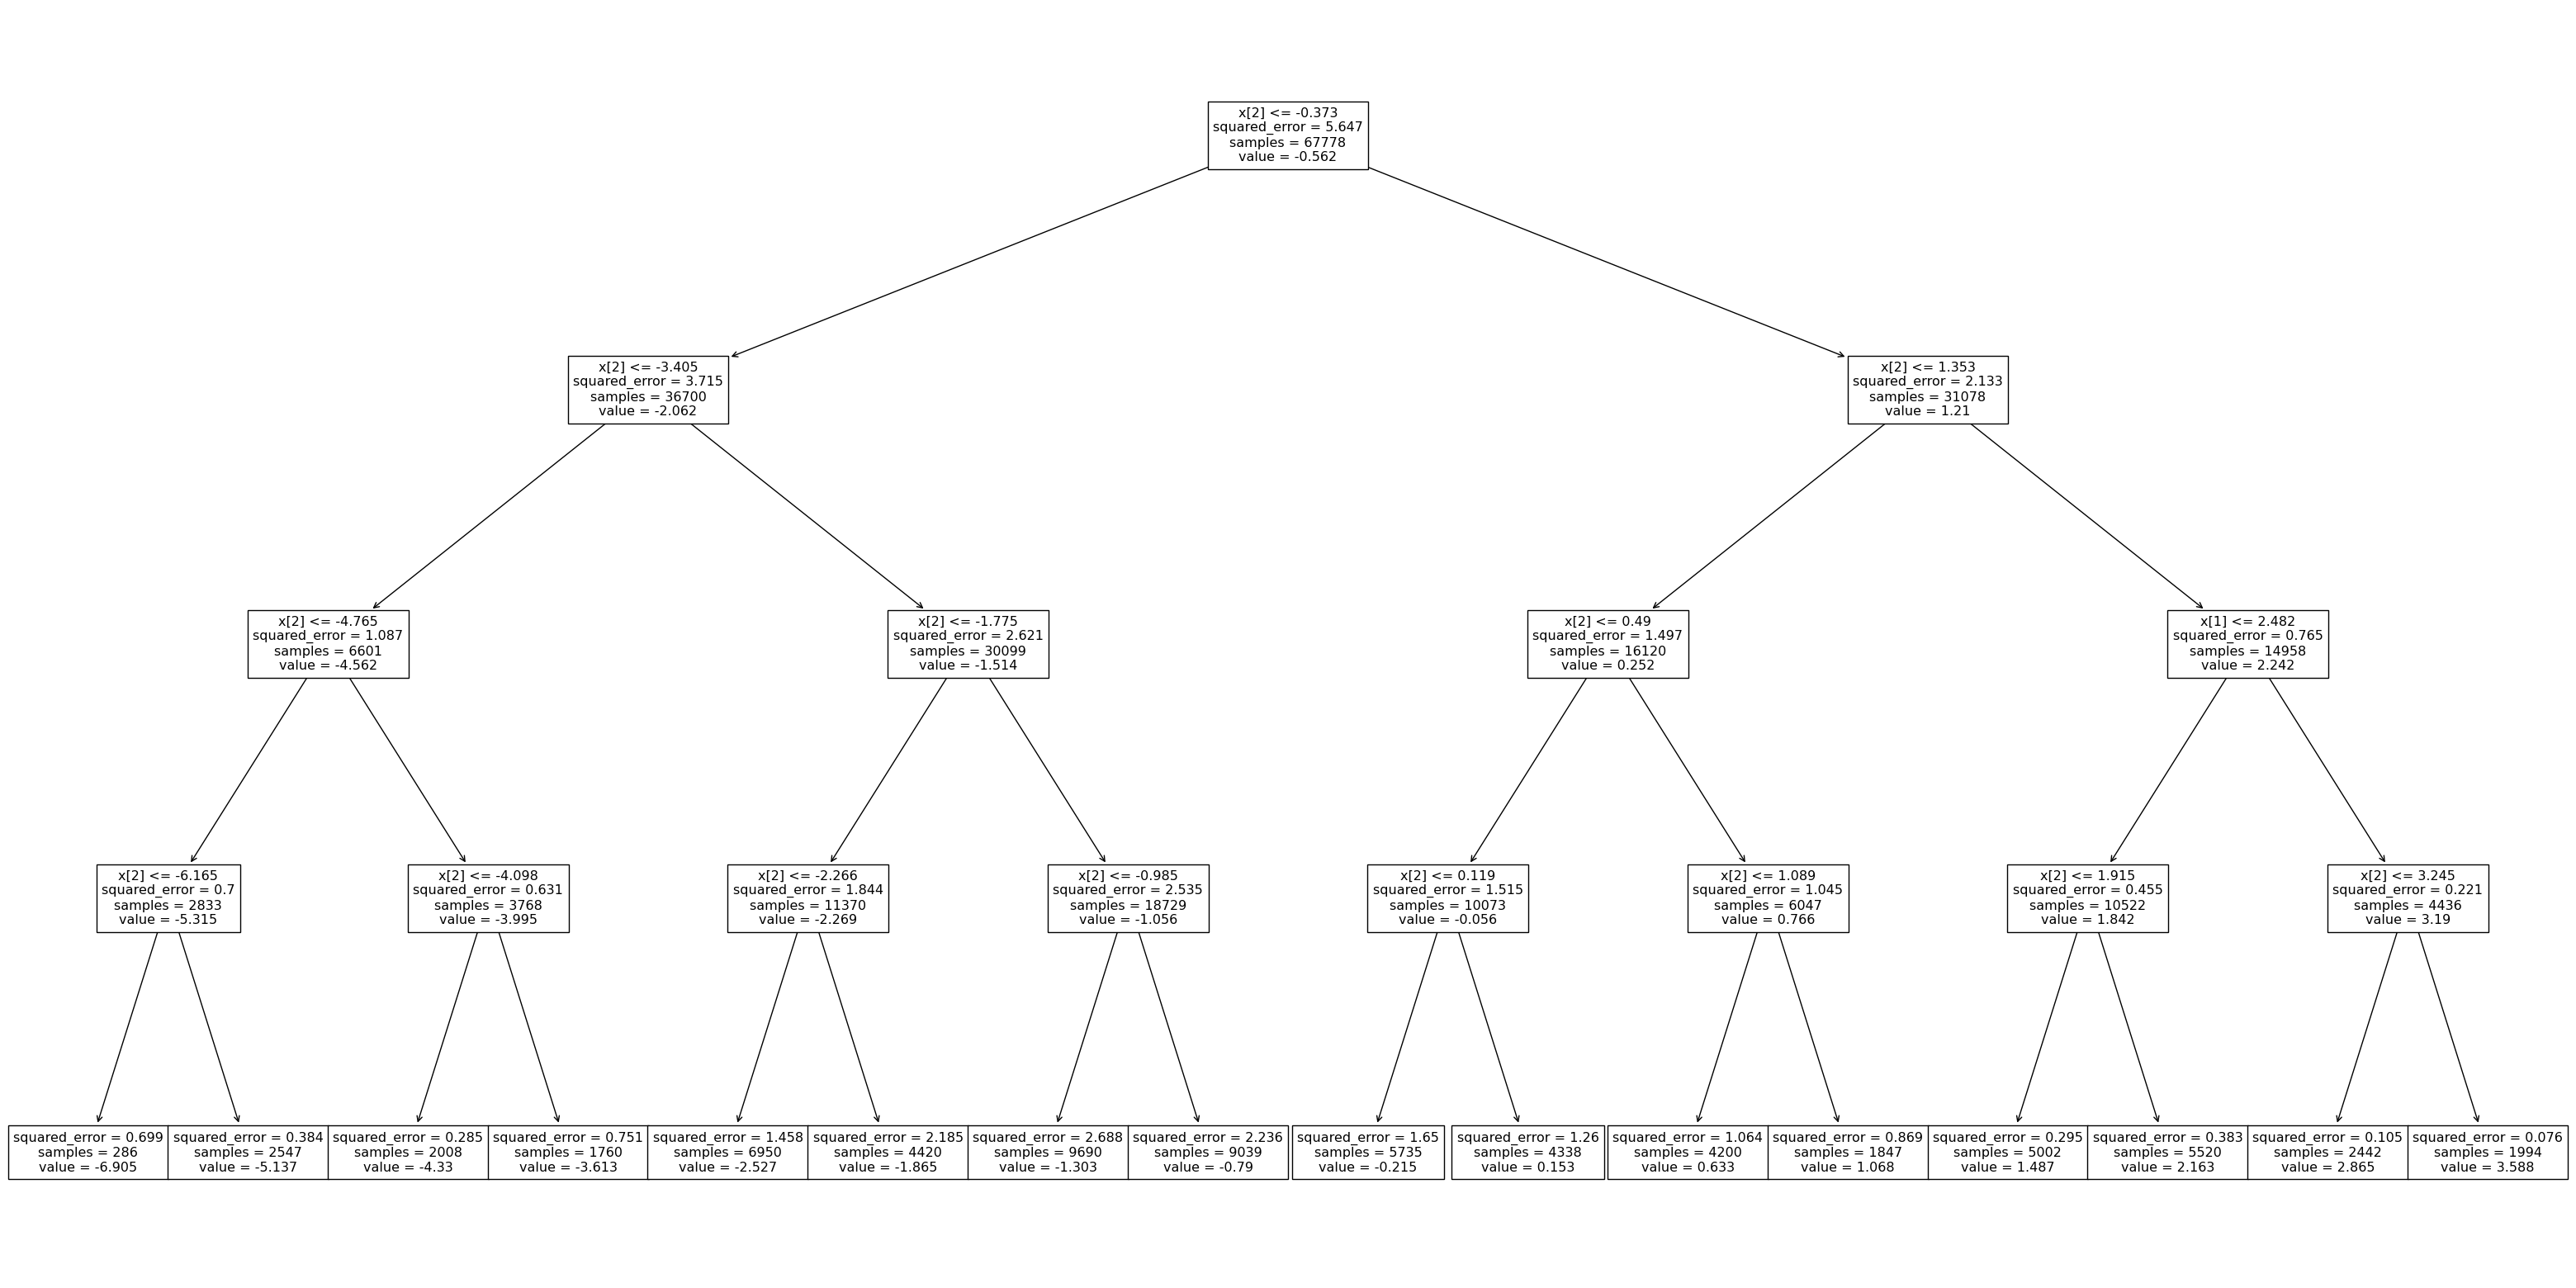

In [42]:
from sklearn.tree import plot_tree
plt.figure(figsize=(40,20))
plot_tree(fitted_stack.final_estimator_, class_names=True)
plt.show()

In [45]:
cv_stacked_preds = fitted_stack.predict(final_test_X)

print(root_mean_squared_error(cv_stacked_preds, test_y))

1.7907314522668176


In [23]:
from sklearn.ensemble import RandomForestRegressor
pipe = Pipeline([
                  ('model', RandomForestRegressor(max_depth=3, min_samples_split=10,
                                   max_features=2, n_estimators=100,
                                   random_state=0, oob_score=True))])

params = {'model__max_depth': [3, 5],
          'model__min_samples_split': [20,60],
          'model__max_features': [5,7,10],
          'model__n_estimators': [50,100,200]

         }


## Perform the grid search
grid_forest = GridSearchCV(pipe, param_grid=params, cv=5, scoring = 'neg_root_mean_squared_error').fit(final_X, train_y)
print(grid_forest.best_estimator_)
print(grid_forest.best_score_)


KeyboardInterrupt: 

# Network

In [31]:
import string
all_letters = string.ascii_letters + " @.,;'!&*~"
n_letters = len(all_letters)

max_length_train = max(len(text) for text in train_X)
max_length_test = max(len(text) for text in test_X)


## Function to iterate through a line of text encode each letter as a 1 x 57 vector in an nchar x 1 x 57 tensor
def textToTensor(line, max_length):
    tensor = torch.zeros(max_length, 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

In [ ]:
train_X_tensor = torch.stack([textToTensor(text, max_length_train) for text in train_X])
train_y_tensor = torch.tensor(train_y.values, dtype=torch.long)
test_X_tensor = torch.stack([textToTensor(text, max_length_test) for text in test_X])
test_y_tensor = torch.tensor(test_y.values, dtype=torch.long)

In [ ]:
# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Define hyperparameters
input_size = 26
hidden_size = 64
output_size = 1

# Instantiate the model, loss function, and optimizer
model = RNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_X_tensor)
    loss = criterion(outputs.squeeze(), train_y_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation on test set
model.eval()
with torch.no_grad():
    test_outputs = model(test_X_tensor)
    test_loss = criterion(test_outputs.squeeze(), test_y_tensor)
    print(f'Test Loss: {test_loss.item()}')

In [ ]:
class my_rnn(nn.Module):

    ## Constructor commands
    def __init__(self, input_size, hidden_size, output_size):
        super(my_rnn, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    ## Function to generate predictions
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
h_size = 100
rnn = my_rnn(n_letters, h_size, 1)
from torch import nn
class my_rnn(nn.Module):

    ## Constructor commands
    def __init__(self, input_size, hidden_size, output_size):
        super(my_rnn, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    ## Function to generate predictions
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
## Set learning rate
learning_rate = 0.005

## Define cost func
cost_fn = nn.CrossEntropyLoss()

## Training function for a single input (name category, name)
def train(comment, hate_score):

    ## initialize the hidden state
    hidden = rnn.initHidden()

    ## set the gradient to zero
    rnn.zero_grad()

    output, hidden = rnn(comment[i], hidden)

    ## Calculate cost and gradients

    print(output)
    print(hate_score)

    cost = cost_fn(output, hate_score)

    cost.backward()

    # Update parameters
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate) ## This adds the LR times the gradient to each parameter

    ## Return the output and cost
    return output, cost.item()

In [ ]:
## Initializations
import random

epochs = 10
cost_every_n = 25
current_cost = 0
track_cost = []

n = len(train_y)
idx = random.sample(range(n), n)


### Iteratively update model from randomly chosen example
for i in range(1, epochs + 1):
    for si in range(n):
      random_y = torch.tensor(train_y.iloc[idx[si]], dtype=torch.long).unsqueeze(0)
      print(random_y)
      random_x = nameToTensor(train_X.iloc[idx[si]])

      output, cost = train(random_x, random_y)
      current_cost += cost

      # Save cost every 25 iterations
      if si % cost_every_n == 0:
          track_cost.append(current_cost/cost_every_n)
          current_cost = 0

In [ ]:
predictions=[]
def predict(input_line):
    print('\n> %s' % input_line)

    ## Don't update gradient with any of these examples
    with torch.no_grad():

        ## Initialize new hidden state
        hidden = rnn.initHidden()

        ## Convert input str to tensor
        input_t = nameToTensor(input_line)

        ## Pass each character into `rnn`
        for i in range(input_t.size()[0]):
            output, hidden = rnn(input_t[i], hidden)

        predicted.append(output)
